<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization-of-the-environment" data-toc-modified-id="Initialization-of-the-environment-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization of the environment</a></span></li><li><span><a href="#Choose-the-file" data-toc-modified-id="Choose-the-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Choose the file</a></span></li><li><span><a href="#Import-dataset" data-toc-modified-id="Import-dataset-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import dataset</a></span></li><li><span><a href="#Compute-Spectrum" data-toc-modified-id="Compute-Spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compute Spectrum</a></span></li><li><span><a href="#Peak-Detection" data-toc-modified-id="Peak-Detection-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Peak Detection</a></span></li><li><span><a href="#Calibration" data-toc-modified-id="Calibration-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calibration</a></span></li><li><span><a href="#Calibration-on-reference-peaks" data-toc-modified-id="Calibration-on-reference-peaks-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Calibration on reference peaks</a></span><ul class="toc-item"><li><span><a href="#To-come-soon-!" data-toc-modified-id="To-come-soon-!-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span><em>To come soon !</em></a></span></li></ul></li><li><span><a href="#Save-processed-data" data-toc-modified-id="Save-processed-data-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save processed data</a></span></li><li><span><a href="#superimpose-spectra" data-toc-modified-id="superimpose-spectra-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>superimpose spectra</a></span></li></ul></div>

# FTICR-MS Processing and Display

a simplified environment for processing 1D Bruker FTICR datasets with `SPIKE`

Run each python cell in sequence by using the ⇥Run button above (or typing *shift* Enter).

Cells are meant to be used in order, taking you to the complete analysis, but you can go back at any time.


### Initialization of the environment
the following cell should be run only once, at the beginning of the processing

In [1]:
# load all python and interactive tools
from __future__ import print_function, division
from IPython.display import display, HTML, Markdown, Image
display(Markdown('## STARTING Environment...'))
%matplotlib notebook
import os.path as op
import numpy as np
import spike
from spike.Interactive import INTER as I
from spike.Interactive import FTICR_INTER as FI
from spike.Interactive.ipyfilechooser import FileChooser
from spike.File import BrukerMS
display(Markdown('## ... program is Ready'))
I.hidecode()

## STARTING Environment...


          SPIKE
    Version     : 0.99.10
    Date        : 18-07-2019
    Revision Id : 415
*** zoom3D not loaded because of an error ***
plugins loaded:
Bruker_NMR_FT,  Bucketing,  FTMS_calib,  Fitter,  Integrate,  Linear_prediction,  PALMA,  Peaks,  apmin,  bcorr,  bokeh_display,  fastclean,  gaussenh,  pg_sane,  rem_ridge,  sane,  sg,  test,  urQRd,  wavelet, 

spike.plugins.report() for a short description of each plugins
spike.plugins.report('module_name') for complete documentation on one plugin


## ... program is Ready

### Choose the file
Use `FileChooser()` to choose a file on your disk - The optional `base` argument, starts the exploration on a given location.

Bruker files are named `fid` and are contained in a `*.d` directory.

In [3]:
FC = FileChooser(path='/DATA', filetype='fid')
display(FC)

FileChooser(path='/DATA', filename='', show_hidden='False')

(After the selection, the selected filename is found in the `FC.selected` variable)
### Import dataset


Reading file  /DATA/Beats Lysozyme/120514_lysoRedDenat_000001.d/fid


<IPython.core.display.Javascript object>


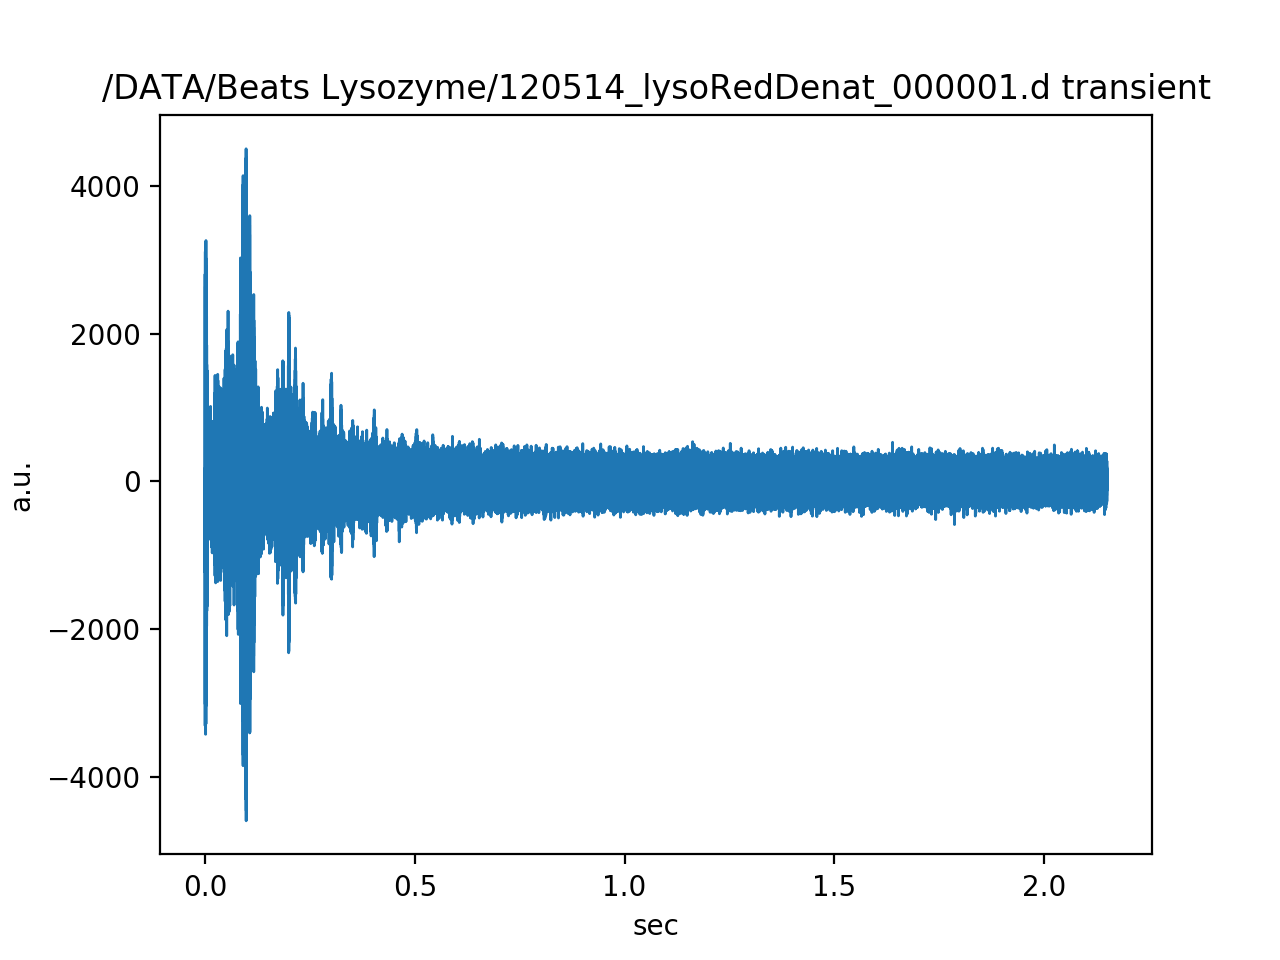

1D data-set
Axis F1 :FT-ICR report axis at 243.902439 kHz,  1048576 real points,  from physical mz =  591.611   to m/z = 1800.000  R max (M=400) = 1549774
data-set is real

In [4]:
# This is simply done with the `Import_1D()` tool, which returns a `SPIKE` object.
# We store it into a variable, evaluating the variable show a summary of the dataset. 
print('Reading file ',FC.selected)
d1 = BrukerMS.Import_1D(FC.selected)
d1.filename = FC.selected
d1.set_unit('sec').display(title=FC.selected_path+" transient")
d1

In the current set-up, the figure can be explored *(zoom, shift, resize, etc)* with the jupyter tools displayed  below the dataset.
The figure can also be saved as a `png` graphic file.

At anytime, the figure can be frozen by clicking on the blue button on the upper right corner, just rerun the cell for changing it.

### Compute Spectrum

many processing methods are available, they can be either applied one by one, or piped by chaining them.

Here we are chaining  apodisation - zerofill - FT - modulus

then setting to `m/z` unit (`Hz` and `points` also available) - finally `display()` is used to display the dataset.


<IPython.core.display.Javascript object>


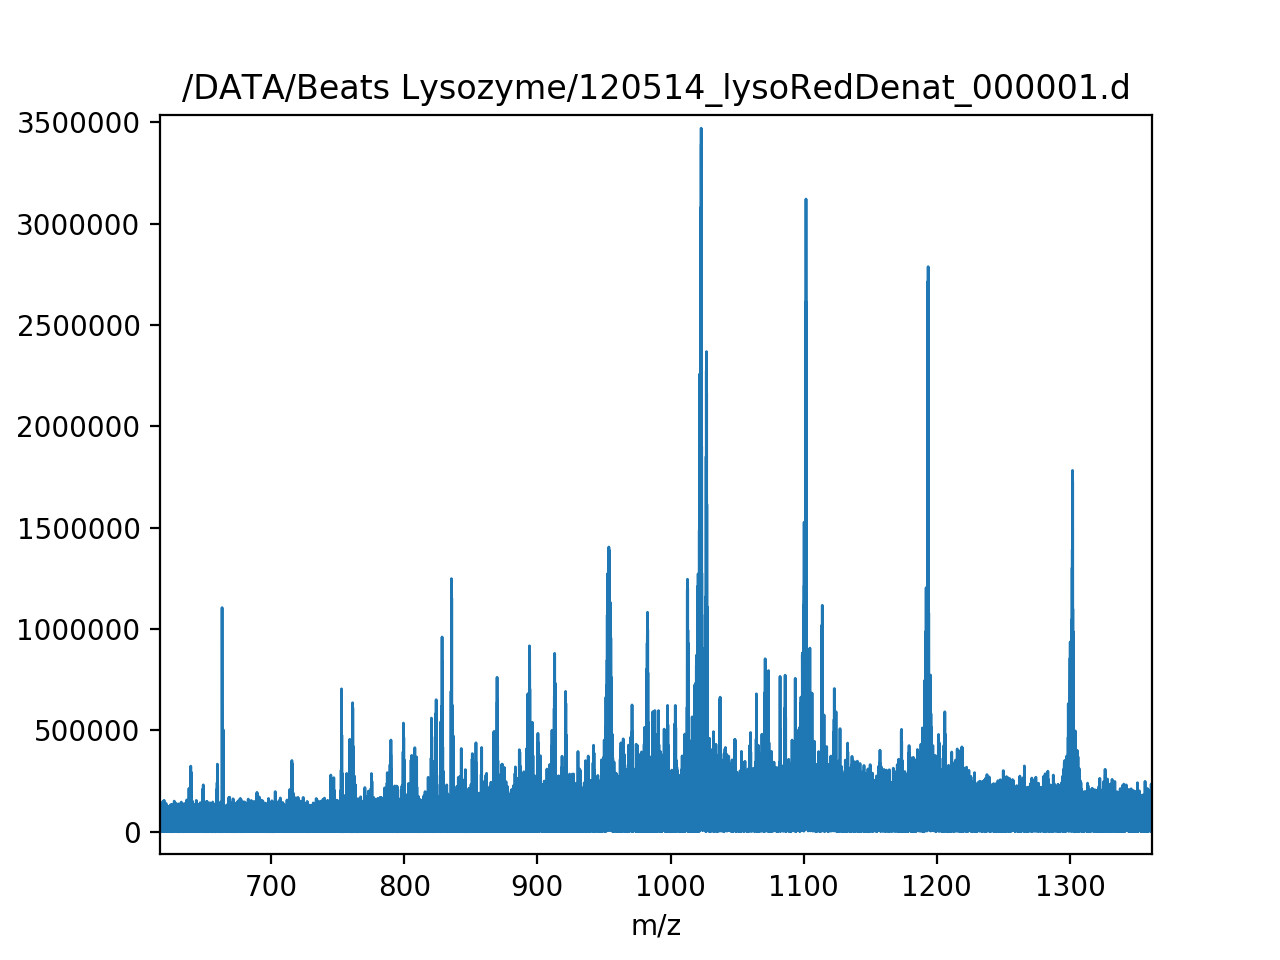

1D data-set
Axis F1 :FT-ICR report axis at 243.902439 kHz,  2097152 real points,  from physical mz =  591.611   to m/z = 1800.000  R max (M=400) = 3099549
data-set is real

In [5]:
D1 = d1.copy() # copy the imported data-set to another object for processing
D1.kaiser(4).zf(4).rfft().modulus() # kaiser(4) is an apodisation well adapted to FTICR, slightly more resolution than hamming(
D1.set_unit('m/z').display(title=FC.selected_path)  # set to ppm unit - and display

### Peak Detection
The following is used to perform an interactive peak picking, and output the result
Use the cursor to choose the sensitivity of the picker.

number of on-screen peaks is limited to 1000 - zoom in with the top tool to be sure of visualizing them all


<IPython.core.display.Javascript object>


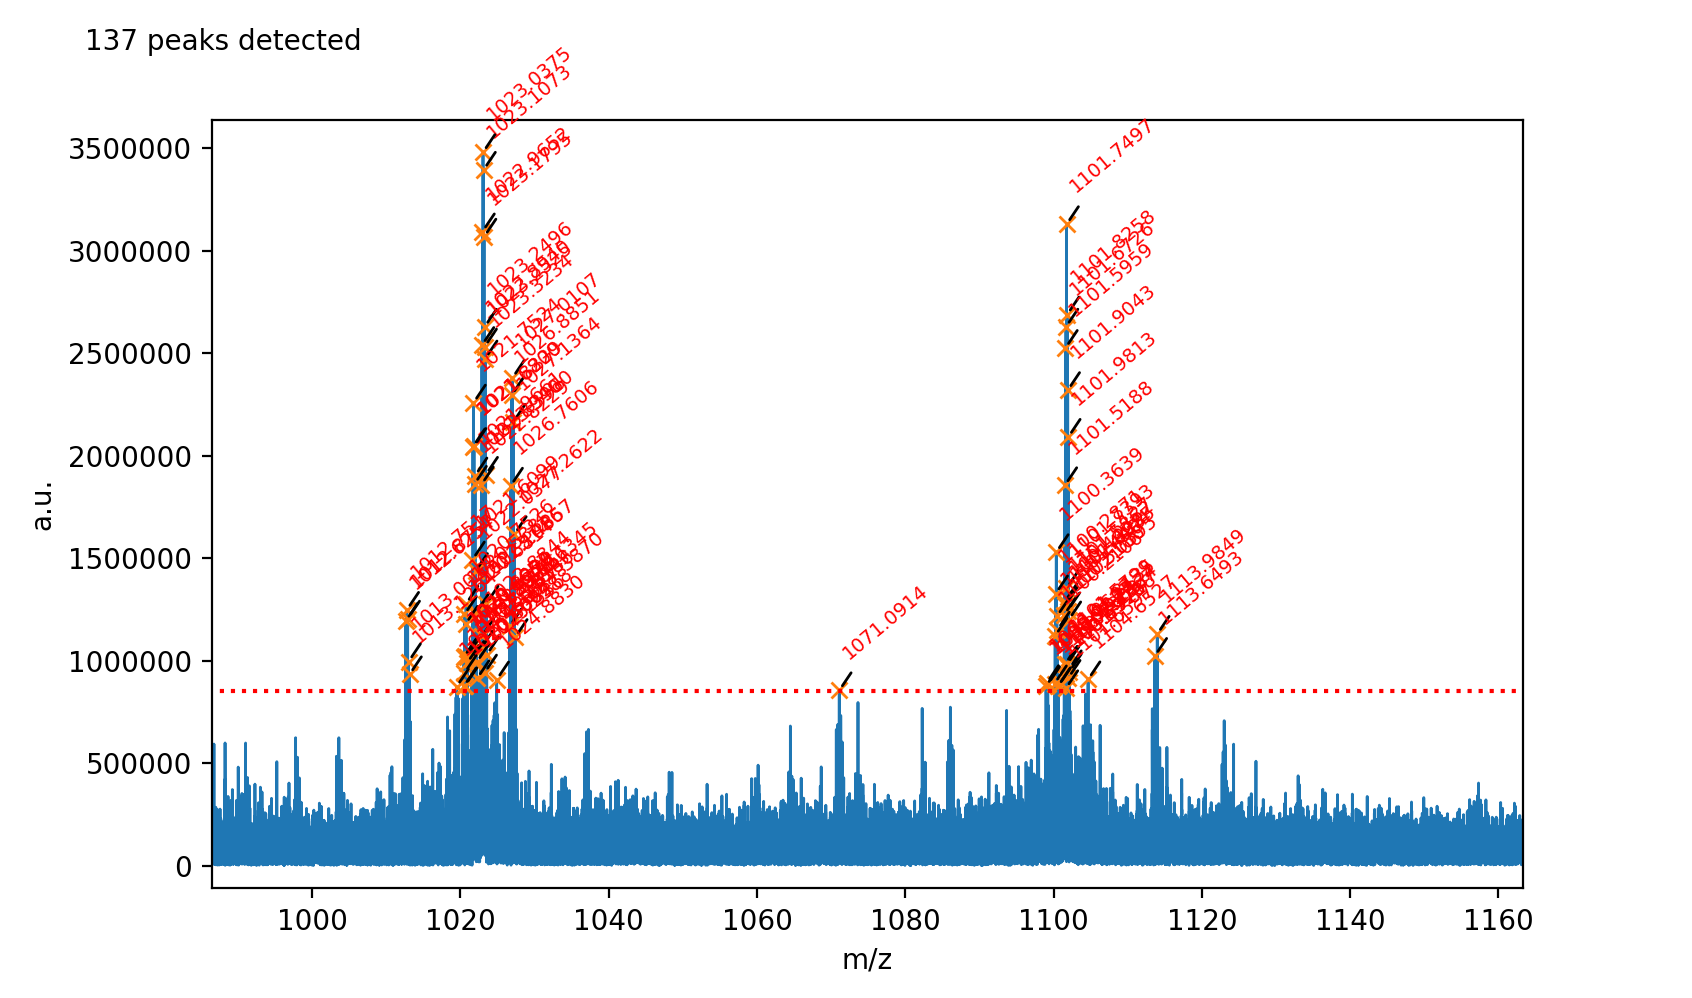

Output(layout=Layout(border='1px solid red'))

In [6]:
pkname = op.join(op.dirname(FC.selected),"peak_list.txt")
import spike.plugins.Peaks
print("number of on-screen peaks is limited to %d - zoom in with the top tool to be sure of visualizing them all"%(spike.plugins.Peaks.NbMaxDisplayPeaks))
FI.MSPeaker(D1, pkname);

### Calibration
The calibration used by SPIKE is based on a 2 or 3 parameters equation :
$$
f = \frac{A}{m/z} - B + \frac{C}{(m/z)^2}
$$
You can change them below:


In [7]:
FI.Calib(D1);

---

### Calibration on reference peaks
#### *To come soon !*


### Save processed data
You can save a dataset, two formats are available:

- Native SPIKE format, `*.msh5` where all informations are stored - run the following cell

In [9]:
msh5name = op.join(op.dirname(FC.selected),"SpikeProcessed.msh5")
D1.save_msh5(msh5name, compressed=True)
print("File is stored as %s"%msh5name)

File is stored as /DATA/Beats Lysozyme/120514_lysoRedDenat_000001.d/SpikeProcessed.msh5


- Or `cvs` format, with only the spectrum (for the peak list, see above) - ( *be carefull this file can be very big*)

In [10]:
csvname = op.join(op.dirname(FC.selected),"SpikeProcessed.csv")
D1.save_csv(csvname)
print("File is stored as %s"%csvname)

File is stored as /DATA/Beats Lysozyme/120514_lysoRedDenat_000001.d/SpikeProcessed.csv


### superimpose spectra
you can superimpose several spectra stored as `.msh5` files in order to compare them

In [11]:
from IPython.display import display
SP = FI.SuperImpose(base='/DATA',N=6).Show()

Label(value='Select a file, and click on the Copy button to copy it to the chosen slot')

Button(button_style='info', description='Display', layout=Layout(width='10%'), style=ButtonStyle(), tooltip='d…

Output(layout=Layout(border='1px solid black'))

*the following cell display the colormap used here*

<IPython.core.display.Javascript object>


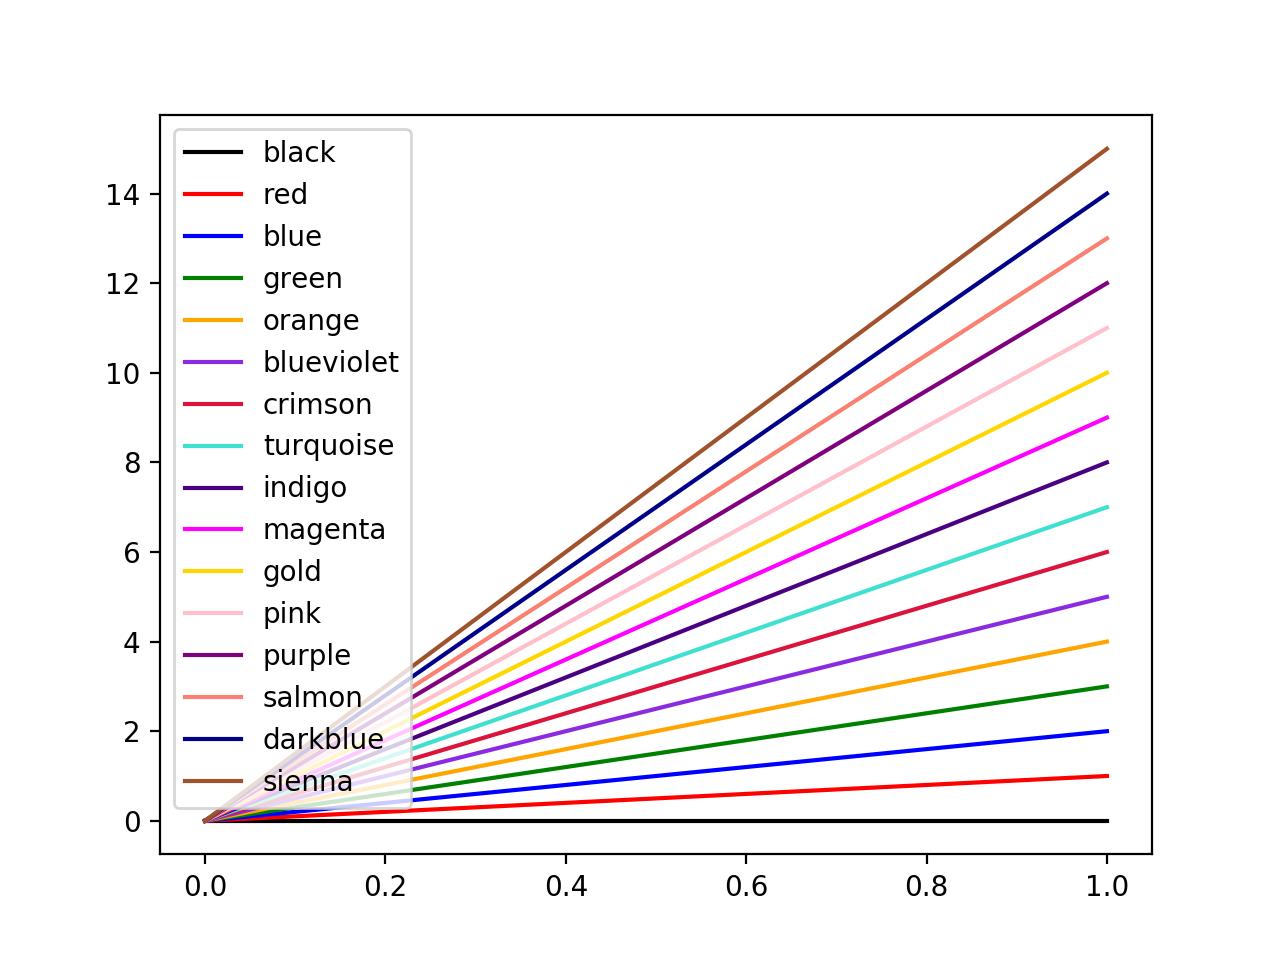

In [12]:
import matplotlib.pylab as plt
plt.figure()
for i ,c in enumerate(FI.Colors):
    plt.plot([0,1],[0,i],'-',color=c,label=c)
plt.legend()